In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

# Read the news dataset
df=pd.read_csv('drive/MyDrive/Deep_Learning/guardian_articles.csv')
# df = pd.read_csv("articles.csv")

df=df.dropna()
df=df[:50000]
# Define the maximum number of words to use
max_words = 10000

# Define the maximum length of a news article
max_len = 1000

vc = df['sectionName'].value_counts()  
keep_classes = vc.index[vc >= 1000]  # get classes with counts >= 1000
df = df[df['sectionName'].isin(keep_classes)]
# 
# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['bodyContent'])
sequences = tokenizer.texts_to_sequences(df['bodyContent'])

# Pad the sequences
data = pad_sequences(sequences, maxlen=max_len)

# Create one-hot-encoded labels
labels = to_categorical(df['sectionName'].astype('category').cat.codes)

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

In [5]:
df['sectionName'].value_counts()

Opinion               4172
World news            3852
Sport                 3627
Football              3608
Music                 2398
Politics              2361
US news               2337
Business              2170
UK news               2127
Australia news        2120
Life and style        1880
Film                  1841
Books                 1780
Society               1489
Television & radio    1468
Environment           1354
Media                 1053
Technology            1016
Name: sectionName, dtype: int64

In [6]:

import tensorflow as tf
# Load the GloVe embeddings
embeddings_index = {}
f = open('drive/MyDrive/Deep_Learning/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(32, dropout=0.2))
model.add(Dense(18, activation='softmax'))

# Load the pre-trained embeddings into the embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compile the model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = model.fit(train_data, train_labels, epochs=20, batch_size=128, validation_split=0.2)



Epoch 1/20
204/204 [==============================] - 10s 38ms/step - loss: 2.4960 - acc: 0.2328 - val_loss: 2.2532 - val_acc: 0.2786
Epoch 2/20
204/204 [==============================] - 7s 32ms/step - loss: 2.1940 - acc: 0.3062 - val_loss: 2.1069 - val_acc: 0.3141
Epoch 3/20
204/204 [==============================] - 7s 34ms/step - loss: 2.0394 - acc: 0.3451 - val_loss: 1.9090 - val_acc: 0.3812
Epoch 4/20
204/204 [==============================] - 7s 32ms/step - loss: 2.0663 - acc: 0.3429 - val_loss: 1.8717 - val_acc: 0.3866
Epoch 5/20
204/204 [==============================] - 7s 34ms/step - loss: 1.8489 - acc: 0.4029 - val_loss: 1.7242 - val_acc: 0.4243
Epoch 6/20
204/204 [==============================] - 7s 32ms/step - loss: 1.6989 - acc: 0.4528 - val_loss: 1.8092 - val_acc: 0.4558
Epoch 7/20
204/204 [==============================] - 7s 35ms/step - loss: 1.5679 - acc: 0.4978 - val_loss: 1.4449 - val_acc: 0.5274
Epoch 8/20
204/204 [==============================] - 7s 32ms/step -

In [7]:
from keras.models import Sequential, load_model
import pickle
#saving model
model.save('Globe_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('Globe_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [10]:
acc = model.evaluate(test_data,test_labels ,verbose=0) # verbose kept 0 to avoid way too big progress bar
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

Test set
  Loss: 0.828
  Accuracy: 0.747


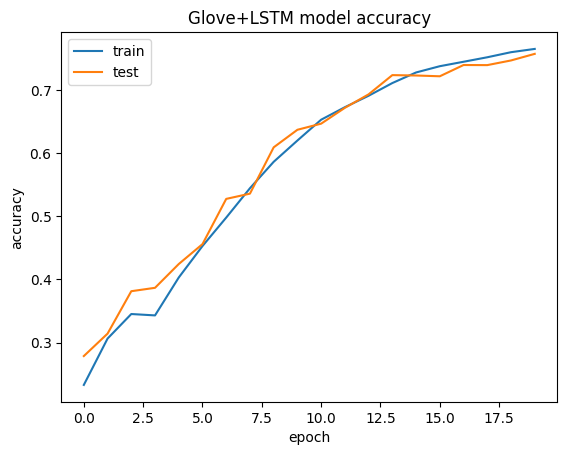

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Glove+LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

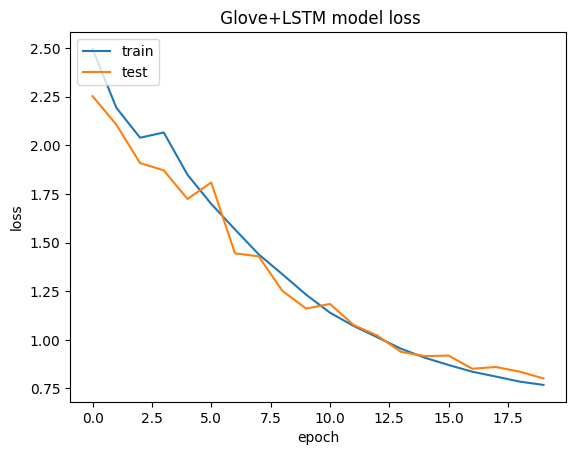

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' Glove+LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')